In [15]:
import zipfile
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import boto3
import pandas as pd
from io import BytesIO
from io import StringIO
import seaborn as sns

In [2]:
# Initialize S3 client
s3 = boto3.client('s3')

# Function to load data 
bucket_name = 'ml-stack-759578648427-us-west-2'

def from_s3(bucket_name, file_name):
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    ext = os.path.splitext(file_name)[1]
    if ext == '.gz':
        data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')
    elif ext == '.csv':
        data = pd.read_csv(BytesIO(response['Body'].read()))
    else:
        data = pd.read_excel(BytesIO(response['Body'].read()), sheet_name='DX_to_CCSR_Mapping', header=1)
    return data

# Import Labled Data Set

In [29]:
file_name = 'MIMIC/final_subject_charttime_df.csv.gz'
df = from_s3(bucket_name, file_name) 
df['charttime'] = pd.to_datetime(df['charttime'])
subjects = df['subject_id'].unique()
df.head()

,subject_id,charttime
0,10000826,2146-12-08 22:22:00
1,10000898,2187-09-26 08:00:00
2,10000980,2185-10-24 00:00:00
3,10001122,2142-04-08 10:48:00
4,10001401,2134-10-09 13:45:00


# + OMR

In [30]:
file_name = 'MIMIC/omr.csv.gz'
omr = from_s3(bucket_name, file_name) 
omr['chartdate'] = pd.to_datetime(omr['chartdate'])
omr = omr[omr['subject_id'].isin(subjects)]
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
261,10000826,2146-12-26,1,Blood Pressure,88/58
262,10000826,2146-12-26,1,Weight (Lbs),98.9
263,10000826,2146-12-30,1,Blood Pressure,104/69
264,10000826,2147-01-15,1,Blood Pressure,102/60
265,10000826,2147-01-15,1,Weight (Lbs),144.75


In [31]:
# pivot columns using result_name
omr = omr.pivot(index=['subject_id', 'chartdate', 'seq_num'], columns='result_name', values='result_value').rename_axis(None,axis=1)

# only keep records that have changes
omr = omr.reset_index().drop(['seq_num'], axis=1).drop_duplicates()

# replace columns with alternatives if null
omr['Blood Pressure'].fillna(omr['Blood Pressure Sitting'], inplace=True)
omr['Blood Pressure'].fillna(omr['Blood Pressure Standing'], inplace=True)
omr['Blood Pressure'].fillna(omr['Blood Pressure Lying'], inplace=True)
omr['Blood Pressure'].fillna(omr['Blood Pressure Standing (1 min)'], inplace=True)
omr['Blood Pressure'].fillna(omr['Blood Pressure Standing (3 mins)'], inplace=True)
omr['Height (Inches)'].fillna(omr['Height'], inplace=True)
omr['Weight (Lbs)'].fillna(omr['Weight'], inplace=True)
omr['Weight (Lbs)'].fillna(omr['Weight'], inplace=True)

# split blood pressure
omr[['bp_systolic', 'bp_diastolic']] = omr['Blood Pressure'].str.split('/', expand=True)
omr.drop(columns=['Blood Pressure', 'Blood Pressure Sitting', 'Blood Pressure Standing', 'Blood Pressure Lying', 'Blood Pressure Standing (1 min)', 'Blood Pressure Standing (3 mins)',
                  'BMI', 'eGFR', 'BMI (kg/m2)', 'Height', 'Weight'], inplace=True)

# change data types
omr = omr.replace(to_replace='.', value=np.nan)
omr[['Height (Inches)', 'Weight (Lbs)', 'bp_systolic', 'bp_diastolic']] = omr.iloc[:, 2:].astype(float)

# average per patient per chart date
omr= omr.groupby(['subject_id', 'chartdate']).mean().reset_index()

omr.head()

/tmp/ipykernel_1953/3245741753.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  omr['Blood Pressure'].fillna(omr['Blood Pressure Sitting'], inplace=True)
/tmp/ipykernel_1953/3245741753.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

,subject_id,chartdate,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic
0,10000826,2146-12-26,NaN,98.900,88.000,58.000
1,10000826,2146-12-30,NaN,NaN,104.000,69.000
2,10000826,2147-01-15,NaN,144.750,102.000,60.000
3,10000826,2147-02-11,NaN,140.000,90.000,60.000
4,10000826,2147-10-26,NaN,135.000,101.000,64.000


In [32]:
# join to df
df_omr = df.merge(omr, on=['subject_id'], how='left')

# get average measures within last year leading up to charttime
df_omr['chartdate'] = df_omr['chartdate'].fillna(df_omr['charttime'])
df_omr['date_diff'] = (df_omr['charttime'] - df_omr['chartdate']).dt.days
df_omr['date_diff'] = np.where(df_omr['date_diff'] >= 0, 1, 0)
df_omr.loc[df_omr['date_diff'] == 0, 'Height (Inches)':'bp_diastolic'] = np.nan

# drop
df_omr.drop(columns=['chartdate', 'date_diff'], inplace=True)

# average multiple columns and groupby
df_omr = df_omr.groupby(['subject_id', 'charttime']).mean().reset_index()

print(df_omr.shape)
df_omr.head()
del df, omr

(44918, 6)


# + Patients

In [33]:
file_name = 'MIMIC/patients.csv.gz'
pt = from_s3(bucket_name, file_name) 
pt = pt[pt.subject_id.isin(subjects)]
pt = pt[['subject_id', 'gender', 'anchor_age', 'anchor_year']].drop_duplicates()
pt.head()

,subject_id,gender,anchor_age,anchor_year
27,10000826,F,32,2146
31,10000898,F,80,2188
38,10000980,F,73,2186
42,10001122,F,70,2142
49,10001401,F,89,2131


In [34]:
# create anchor year from charttime
df_omr['chart_year'] = df_omr['charttime'].dt.year
# join to omr on anchor year
df_omr_pt = df_omr.merge(pt, left_on=['subject_id'], right_on=['subject_id'], how='left')
# group by subject_if & charttime and select record with max anchor year 
df_omr_pt = df_omr_pt.loc[df_omr_pt.groupby(['subject_id', 'charttime'])['anchor_year'].idxmax()]
# adjust age based on latest anchor year 
df_omr_pt['anchor_age'] = df_omr_pt['anchor_age'] + (df_omr_pt['chart_year'] - df_omr_pt['anchor_year'])
df_omr_pt.drop(columns=['chart_year', 'anchor_year'], inplace=True)
del df_omr, pt
df_omr_pt.head()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age
0,10000826,2146-12-08 22:22:00,NaN,NaN,NaN,NaN,F,32
1,10000898,2187-09-26 08:00:00,NaN,NaN,126.000,76.000,F,79
2,10000980,2185-10-24 00:00:00,NaN,173.000,150.000,90.000,F,72
3,10001122,2142-04-08 10:48:00,NaN,NaN,NaN,NaN,F,70
4,10001401,2133-12-15 11:04:00,65.450,167.941,146.537,60.630,F,91


### Clean & Impute

In [35]:
df_omr_pt.describe()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,anchor_age
count,44918.000,44918,24804.000,29227.000,28069.000,28069.000,44918.000
mean,15008362.972,2155-11-13 19:40:29.742196736,64.923,355.784,128.353,72.774,64.246
min,10000826.000,2109-03-19 11:40:00,0.000,0.000,70.000,8.000,17.000
25%,12495580.500,2135-12-22 12:53:30,62.000,140.000,118.227,67.000,53.000
50%,15002051.500,2155-11-02 22:04:30,64.580,166.767,128.125,72.500,67.000
75%,17544474.250,2175-11-29 19:46:00,67.600,201.170,137.667,78.500,79.000
max,19999987.000,2214-12-24 05:14:00,363.000,1781921.394,236.000,135.000,106.000
std,2893254.342,NaN,5.906,17764.632,14.708,9.076,19.028


In [36]:
# clean height and weight 
df_omr_pt['Weight (Lbs)'] = df_omr_pt['Weight (Lbs)'].apply(lambda x: df_omr_pt['Weight (Lbs)'].median() if x > 1400 else x)
df_omr_pt['Height (Inches)'] = df_omr_pt['Height (Inches)'].apply(lambda x: df_omr_pt['Height (Inches)'].median() if x > 96 else x)

array([[<Axes: title={'center': 'subject_id'}>,
        <Axes: title={'center': 'charttime'}>,
        <Axes: title={'center': 'Height (Inches)'}>],
       [<Axes: title={'center': 'Weight (Lbs)'}>,
        <Axes: title={'center': 'bp_systolic'}>,
        <Axes: title={'center': 'bp_diastolic'}>],
       [<Axes: title={'center': 'anchor_age'}>, <Axes: >, <Axes: >]],
      dtype=object)

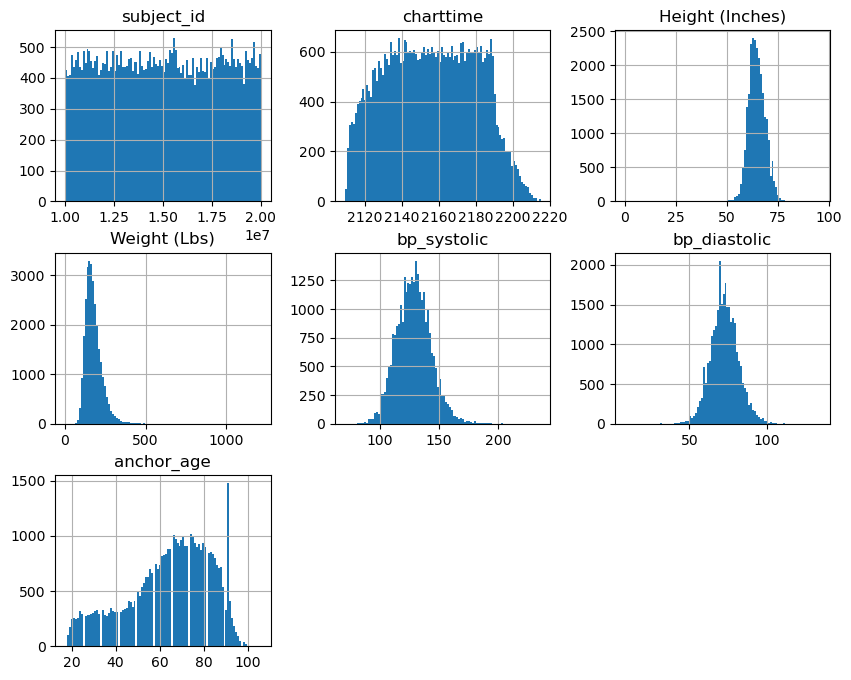

In [37]:
# distributions
df_omr_pt.hist(bins=100, figsize=(10, 8))

In [39]:
# get averages by age & gender 
df_omr_pt['Weight (Lbs)'] = df_omr_pt.groupby(['anchor_age', 'gender'])['Weight (Lbs)'].transform(lambda x: x.fillna(x.mean()))
df_omr_pt['Height (Inches)'] = df_omr_pt.groupby(['anchor_age', 'gender'])['Height (Inches)'].transform(lambda x: x.fillna(x.mean()))
df_omr_pt['bp_systolic'] = df_omr_pt.groupby(['anchor_age', 'gender'])['bp_systolic'].transform(lambda x: x.fillna(x.mean()))
df_omr_pt['bp_diastolic'] = df_omr_pt.groupby(['anchor_age', 'gender'])['bp_diastolic'].transform(lambda x: x.fillna(x.mean()))

In [40]:
df_omr_pt.describe()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,anchor_age
count,44918.000,44918,44916.000,44916.000,44915.000,44915.000,44918.000
mean,15008362.972,2155-11-13 19:40:29.742196736,64.810,175.400,128.159,72.680,64.246
min,10000826.000,2109-03-19 11:40:00,0.000,0.000,70.000,8.000,17.000
25%,12495580.500,2135-12-22 12:53:30,62.500,147.863,120.722,68.969,53.000
50%,15002051.500,2155-11-02 22:04:30,64.019,171.720,129.147,72.429,67.000
75%,17544474.250,2175-11-29 19:46:00,67.750,193.633,134.250,76.590,79.000
max,19999987.000,2214-12-24 05:14:00,96.000,1213.180,236.000,135.000,106.000
std,2893254.342,NaN,3.705,44.533,12.304,7.450,19.028


# + Admissions

In [41]:
file_name = 'MIMIC/admissions.csv.gz'
ad_raw = from_s3(bucket_name, file_name) 
ad_raw = ad_raw[ad_raw.subject_id.isin(subjects)]
# select needed variables
ad = ad_raw[['subject_id', 'admittime', 'dischtime', 'insurance', 'language', 'marital_status', 'race']].drop_duplicates()
ad['admittime'] = pd.to_datetime(ad['admittime'])
ad['dischtime'] = pd.to_datetime(ad['dischtime'])
ad.head()

,subject_id,admittime,dischtime,insurance,language,marital_status,race
22,10000826,2146-12-05 19:07:00,2146-12-12 16:30:00,Private,English,SINGLE,WHITE
23,10000826,2146-12-18 17:39:00,2146-12-24 19:55:00,Private,English,SINGLE,WHITE
24,10000826,2146-12-31 00:43:00,2147-01-02 17:45:00,Private,English,SINGLE,WHITE
36,10000980,2193-08-15 01:01:00,2193-08-17 15:07:00,Medicare,English,MARRIED,BLACK/AFRICAN AMERICAN
37,10000980,2190-11-06 20:57:00,2190-11-08 15:58:00,Medicare,English,MARRIED,BLACK/AFRICAN AMERICAN


In [42]:
# join based on subject id to include missing hadm_ids
df_omr_pt_ad = df_omr_pt.merge(ad, on=['subject_id'], how='left')
# identify records where admittime is before charttime
df_omr_pt_ad['is_before'] = np.where((df_omr_pt_ad['admittime'] <= df_omr_pt_ad['charttime']) | df_omr_pt_ad.admittime.isna() == True, 1, 0)
# if admittime is after chartime set admittime:race to null
#df_omr_pt_ad.loc[df_omr_pt_ad['is_before'] == 0, 'admittime':'race'] = np.nan
# drop duplicates
df_omr_pt_ad.drop_duplicates(inplace=True)
# get absolute time difference between charttime and admittime
df_omr_pt_ad['time_diff'] = (df_omr_pt_ad['charttime'] - df_omr_pt_ad['admittime']).dt.days
# filla na time diff with zero
df_omr_pt_ad.loc[df_omr_pt_ad.time_diff.isna(), 'time_diff'] = 0
# fill time diff after with max 
df_omr_pt_ad.loc[df_omr_pt_ad.is_before == 0, 'time_diff'] = 100000
# select minimum time_diff per group
df_omr_pt_ad = df_omr_pt_ad.loc[df_omr_pt_ad.groupby(['subject_id', 'charttime'])['time_diff'].idxmin()]
# if admittime is after chartime set admittime:race to null
df_omr_pt_ad.loc[df_omr_pt_ad['is_before'] == 0, 'admittime':'race'] = np.nan
# drop time_diff
df_omr_pt_ad.drop(columns=['time_diff', 'is_before', 'admittime', 'dischtime'], inplace=True)
print(df_omr_pt_ad.shape)
del df_omr_pt, ad
df_omr_pt_ad.head()

(44918, 12)


,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age,insurance,language,marital_status,race
0,10000826,2146-12-08 22:22:00,63.786,166.608,116.368,73.125,F,32,Private,English,SINGLE,WHITE
3,10000898,2187-09-26 08:00:00,62.251,162.011,126.000,76.000,F,79,NaN,NaN,NaN,NaN
4,10000980,2185-10-24 00:00:00,63.242,173.000,150.000,90.000,F,72,NaN,NaN,NaN,NaN
11,10001122,2142-04-08 10:48:00,62.926,170.767,131.007,72.597,F,70,NaN,NaN,NaN,NaN
17,10001401,2133-12-15 11:04:00,65.450,167.941,146.537,60.630,F,91,Medicare,English,MARRIED,WHITE


In [43]:
df_omr_pt_ad.describe(include='object')

,gender,insurance,language,marital_status,race
count,44918,33432,33590,32667,33646
unique,2,5,25,4,33
top,F,Medicare,English,MARRIED,WHITE
freq,30231,19900,29413,14092,20991


# Export to S3

In [44]:
s3_key = 'MIMIC/Cleaned/df_omr_pt_ad.csv'

# Save the DataFrame to a CSV in memory (using StringIO)
csv_buffer = StringIO()
df_omr_pt_ad.to_csv(csv_buffer, index=False)

# Upload the CSV data to S3
s3.put_object(Bucket=bucket_name, Key=s3_key, Body=csv_buffer.getvalue())

print(f"DataFrame successfully exported to s3://{bucket_name}/{s3_key}")

DataFrame successfully exported to s3://ml-stack-759578648427-us-west-2/MIMIC/Cleaned/df_omr_pt_ad.csv
